<a href="https://colab.research.google.com/github/manku13/PRODIGY_ML_04/blob/main/Hand_Gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem :
> Using the CNN model and training data set we'll have to train the model which will predict the hand gesture from the input image.

## Importing Libraries

Importing important libraries for data manipulation and data disintegration into more robust form.

In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

## Unzipping the raw data

At first we'll have to unzip the data which then will give us all the train and test data.

We've commented this cell because as we want only to run this cell once for unzipping the data. Once we have the unzipped data so then we can proceed furthur.

By commenting this cell also prevent to create multiple copies of the data.

In [1]:
# !unzip "drive/MyDrive/Hand Gesture/archive.zip" -d "drive/MyDrive/Hand Gesture/"

## Understanding the data:

By looping into the data file we'll get to know of how the data is formated and how it is divided into many parts.

Here we'll gone through many different folder of just one training set and represented all into the output below which gives us an brief understanding of the data.

In [4]:
lookup =  dict()
reverselookup = dict()
count = 0
for j in os.listdir("drive/MyDrive/Hand Gesture/leapGestRecog/00/"):
  if not j.startswith("."):
    lookup[j] = count
    reverselookup[count] = j
    count = count+1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

## Assigning the labels to the training data

Here we've explicitly assign the label to the training data which was stored under their respective classes or categories.


In [7]:
x_data = []
# Initialize y_data as a list
y_data = []
datacount = 0

for i in range(0, 10):
    for j in os.listdir("drive/MyDrive/Hand Gesture/leapGestRecog/0" + str(i) + "/"):
        if not j.startswith("."):
            count = 0
            for k in os.listdir("drive/MyDrive/Hand Gesture/leapGestRecog/0" + str(i) + "/" + j + "/"):
                img = Image.open("drive/MyDrive/Hand Gesture/leapGestRecog/0" + str(i) + "/" + j + "/" + k).convert("L")
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr)
                count += 1
            y_values = np.full((count, 1), lookup[j])
            y_data.extend(y_values)  # Use extend instead of append
            datacount += count

# Convert y_data to a numpy array
y_data = np.array(y_data, dtype="float32")

# Reshape y_data
y_data = y_data.reshape(datacount, 1)


### Visualizing the data

Let's take a look at some of the pictures. Since each of the subfolders in 00 contained 200 images, we'll use the following piece of code to load one image of each gesture.

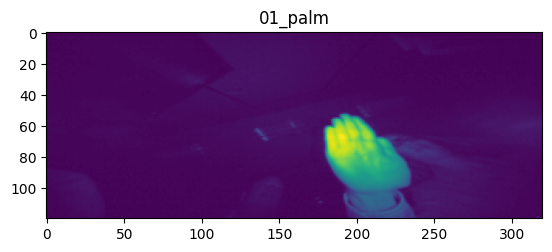

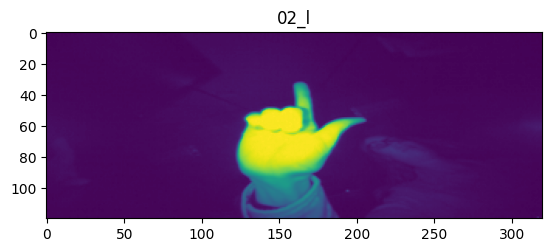

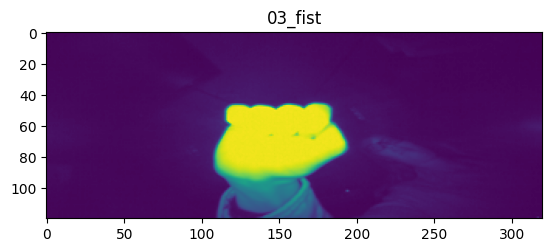

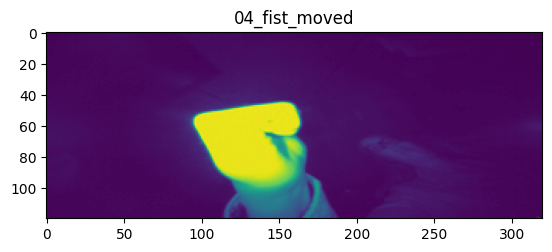

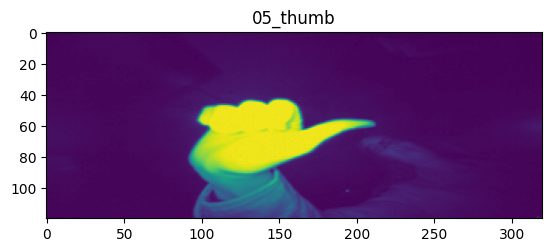

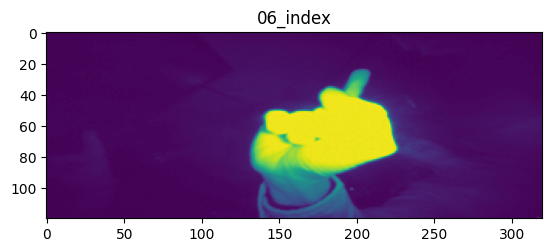

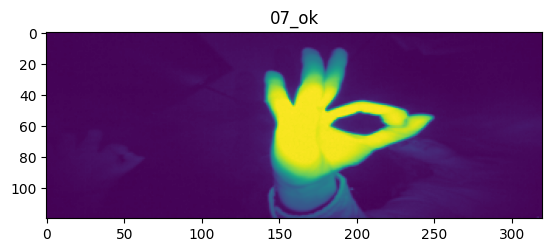

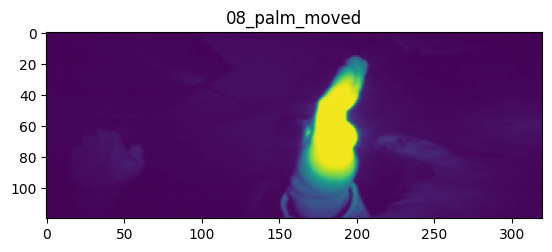

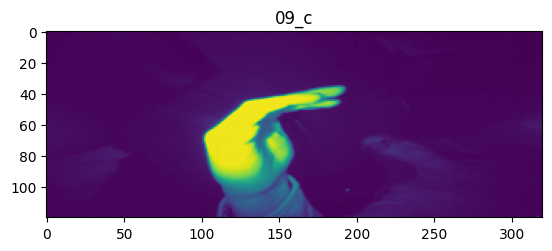

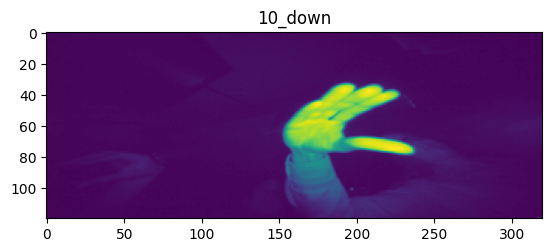

In [12]:
from random import randint
for i in range(0, 10):
    plt.imshow(x_data[i * 200][:, :])
    plt.title(reverselookup[y_data[i * 200][0]])
    plt.show()

## Classification and Model Creating

The first thing to note is that this is not a difficult classification problem. The gestures are quite distinct, the images are clear, and there's no background whatsoever to worry about. If you weren't comfortable with deep learning, you could do quite well with some straight-forward feature detection -- for example the '07_ok' class could easily be detected with binary thresholding followed by circle detection.

Moreover, the gestures consistently occupy only about 25% of the image, and all would fit snugly inside a square bounding box. Again if you're looking to do basic feature detection, an easy first step would be to write a short script cropping everything to the relevant 120 x 120 square.

But the point of this notebook is to show how effective it is to just throw a neural network at a problem like this without having to worry about any of the above, so that's what we're going to do.

At the moment our vector y_data has shape (datacount, 1), with y_data[i,0] = j if the ith image in our dataset is of gesture reverselookup[j]. In order to convert it to one-hot format, we use the keras function to_categorical:

In [13]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

### Reshaping the images

Our set of images has shape (datacount, 120, 320). Keras will be expecting another slot to tell it the number of channels, so we reshape x_data accordingly. We also rescale the values in x_data to lie between 0 and 1.

In [15]:
x_data = np.array(x_data, dtype="float32")
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

### Making Training and Cross-validation and test sets

We need a cross-validation set and a test set, and we'll use the sklearn package to construct these. In order to get an 80-10-10 split, we call train_test_split twice, first to split 80-20, then to split the smaller chunk 50-50. Note that we do this after the rescaling step above, to ensure that our train and test sets are coming from the same distribution.

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_experiment, y_train, y_experiment = train_test_split(x_data,
                                                                y_data,
                                                                test_size = 0.2)
x_valid, x_test, y_valid, y_test = train_test_split(x_experiment,
                                                    y_experiment,
                                                    test_size = 0.5)

### Building the model and fitting the model

Since our images are big (we chose not to do any cropping) and the classification problem looks quite easy, we're going to downsample fairly aggressively, beginning with a 5 x 5 filter with a stride of 2. Note we have to specify the correct input shape at this initial layer, and keras will figure it out from then on. We won't worry about padding since it's clear that all the useful features are well inside the image. We'll continue with a sequence of convolutional layers followed by max-pooling until we arrive at a small enough image that we can add a fully-connected layer. Since we need to classify between 10 possibilities, we finish with a softmax layer with 10 neurons.

In [18]:
from keras import layers
from keras import models

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), strides = (2, 2), activation = "relu", input_shape = (120, 320, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = "relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = "relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(10, activation = "softmax"))

In [21]:
model.compile(optimizer = "rmsprop",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model.fit(x_train, y_train, epochs = 5, batch_size = 32, verbose = 1, validation_data=(x_valid, y_valid))

Epoch 1/5
272/272 [==============================] - 15s 16ms/step - loss: 0.3021 - accuracy: 0.9010 - val_loss: 0.0091 - val_accuracy: 0.9982
Epoch 2/5
272/272 [==============================] - 3s 12ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0095 - val_accuracy: 0.9982
Epoch 3/5
272/272 [==============================] - 3s 12ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0093 - val_accuracy: 0.9972
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 4.5774e-05 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9982
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0056 - val_accuracy: 0.9972


At this point we would typically graph the accuracy of our model on the validation set, and choose a suitable number of epochs to train for to avoid overfitting. We might also consider introducing dropout and regularisation. However, we can see we're getting perfect accuracy on the validation set after just one or two epochs, so we're pretty much done. Let's quickly confirm that this is carrying through to the test set:

In [24]:
[loss, acc] = model.evaluate(x_test, y_test, verbose = 1)
print("Accuracy:" + str(acc))

34/34 [==============================] - 0s 9ms/step - loss: 0.0031 - accuracy: 0.9991
Accuracy:0.9990808963775635


Our model has evaluated quite efficiently it has predicted between `99%` and `100%` which is great!!!

## Saving Model  and Model Weights

In [35]:
model.save_weights("drive/MyDrive/Hand Gesture/models/gesture_model_weights.h5")
model.save("drive/MyDrive/Hand Gesture/models/gesture_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing our model

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import image
import numpy as np

In [37]:
from keras.models import load_model

loaded_model = load_model("drive/MyDrive/Hand Gesture/models/gesture_model.h5")

In [38]:
from keras.preprocessing import image
import numpy as np

In [40]:
t_test = []

datacount = 0 # We'll use this to tally how many images are in our dataset
folder_path = 'drive/MyDrive/Hand Gesture/test_data'

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):

        img_path = os.path.join(folder_path, filename)
        count = 0 # To tally images of a given gesture


        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((320, 120))
        arr = np.array(img)
        t_test.append(arr)
        count = count + 1

    datacount = datacount + count
t_test = np.array(t_test, dtype = 'float32')

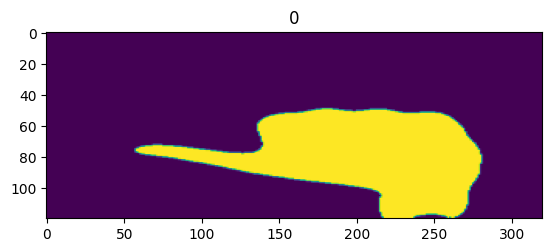

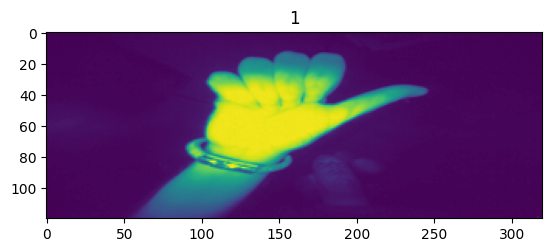

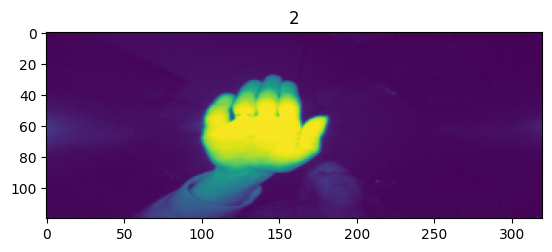

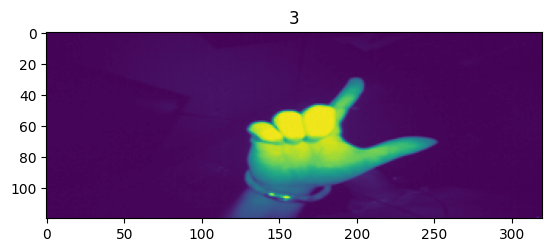

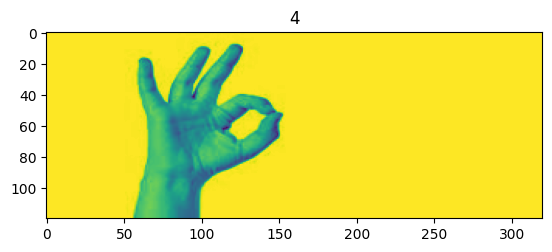

In [41]:
for i in range(0, 5):
    plt.imshow(t_test[i , :, :])
    plt.title(i)
    plt.show()

1/1 [==============================] - 0s 308ms/step


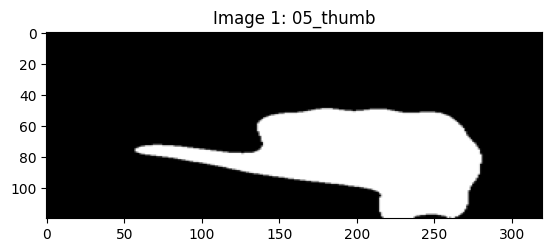

1/1 [==============================] - 0s 64ms/step


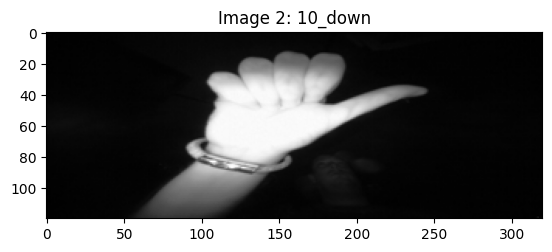

1/1 [==============================] - 0s 109ms/step


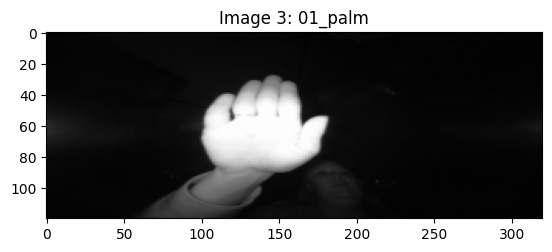

1/1 [==============================] - 0s 27ms/step


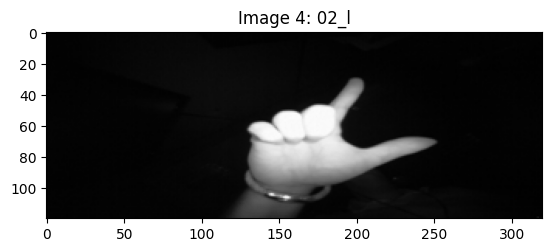

1/1 [==============================] - 0s 19ms/step


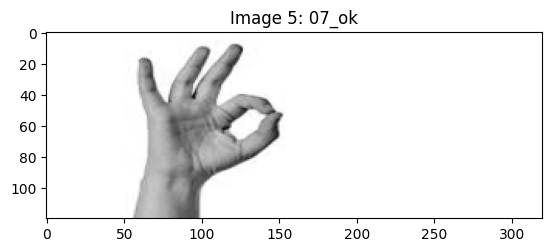

1/1 [==============================] - 0s 21ms/step


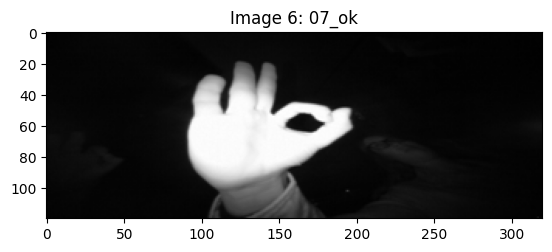

1/1 [==============================] - 0s 19ms/step


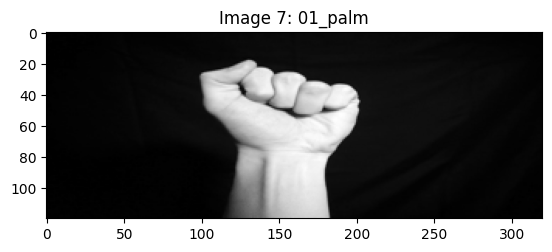

1/1 [==============================] - 0s 18ms/step


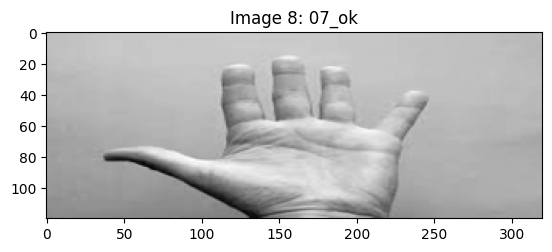

1/1 [==============================] - 0s 19ms/step


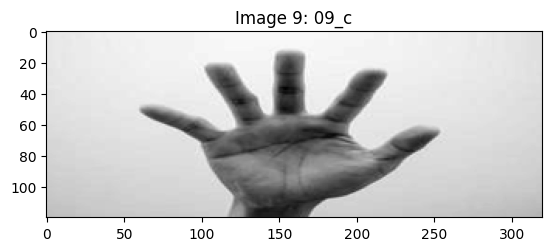

1/1 [==============================] - 0s 17ms/step


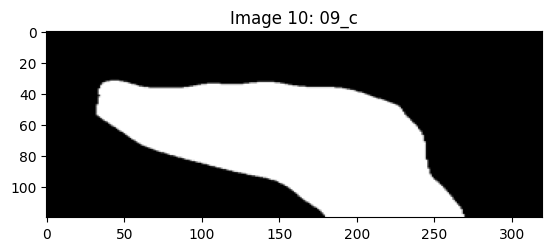

1/1 [==============================] - 0s 20ms/step


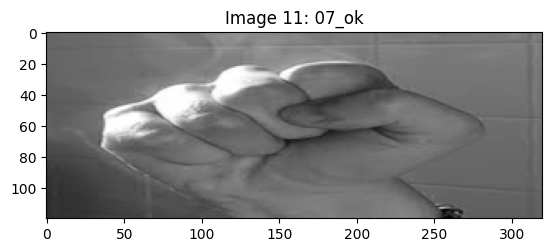

1/1 [==============================] - 0s 20ms/step


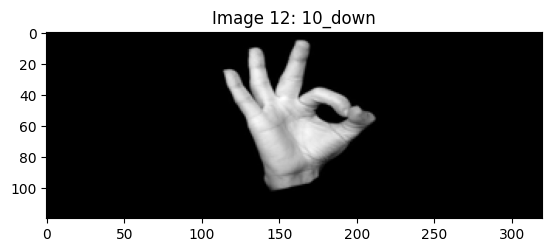

1/1 [==============================] - 0s 91ms/step


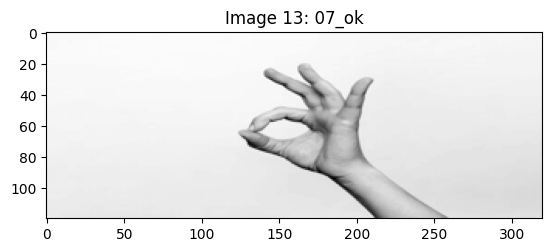

1/1 [==============================] - 0s 18ms/step


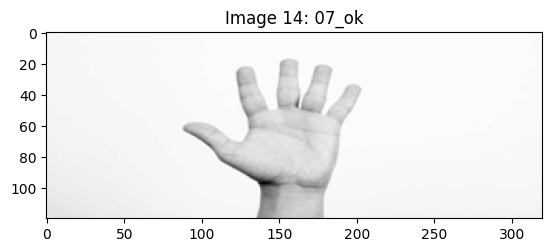

Predicted Gesture: ['05_thumb', '10_down', '01_palm', '02_l', '07_ok', '07_ok', '01_palm', '07_ok', '09_c', '09_c', '07_ok', '10_down', '07_ok', '07_ok']


In [42]:
predicted_gestures = []

for i in range(t_test.shape[0]):
  img_show = t_test[i].reshape(120,320)

  img2 = img_show.reshape(1, 120, 320, 1)
  img2 /=255.0

  predictions = loaded_model.predict(img2)

  predicted_class = np.argmax(predictions)
  predicted_gesture = reverselookup[predicted_class]
  predicted_gestures.append(predicted_gesture)

  plt.imshow(img_show, cmap = "gray")

  plt.title(f"Image {i+1}: {predicted_gesture}")
  plt.show()

print("Predicted Gesture:", predicted_gestures)